In [1]:
# run to download glove embeddings, total 822MB
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d glove
!rm glove.6B.zip

--2024-03-28 13:03:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-03-28 13:03:16--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-03-28 13:03:16--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [2]:
%pip install --upgrade numpy
%pip install --upgrade scikit-learn
%pip install --upgrade pyenchant

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


----
# Glove Embeddings

website available [here](https://nlp.stanford.edu/projects/glove/)

- using embeddings trained on Wikipedia 2014 and Gigaword 5 data
    - 6B tokens, 400K vocab, uncased, up to 300d vectors
    - embeddings come in 50, 100, 200, and 300 dimensions
- starting with 50d embeddings for speed
    - can run with larger embeddings to see difference in algorithm performance


In [1]:
import numpy as np

import re
import string
import pickle
import enchant

# read the 50d embeddings and store in dictionary
glove_50d = {}

# try to read the pickle file first
try:
    with open('glove/glove_50d.pkl', 'rb') as f:
        glove_50d = pickle.load(f)
except:
    with open('glove/glove.6B.50d.txt') as f:
        for line in f: # each line has a word followed by embedding vector (in a list)
            values = line.split()
            word = values[0] 
            
            # filters out words which are solely numbers and/or punctuation
            pattern = re.compile("[\d{}]+$".format(re.escape(string.punctuation)))
            
            # dictionaries to filter out any leftover word fragments and in non-English languages
            en_us = enchant.Dict("en_US")
            en_ca = enchant.Dict("en_CA")
            en_gb = enchant.Dict("en_GB")
            
            if pattern.match(word) or not (en_us.check(word) and en_ca.check(word) and en_gb.check(word)):
                continue

            vector = np.asarray(values[1:], dtype='float32')
            glove_50d[word] = vector


# reverse the mapping
glove_50d_inv = {tuple(v): k for k, v in glove_50d.items()}

print(f'Total words in glove_50d: {len(glove_50d)}')

Total words in glove_50d: 62143


In [2]:
# print the first word and its embedding
w = list(glove_50d.keys())[0]
print(w, glove_50d[w])  

the [ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]


In [10]:
# create a random subset of 10000 words
import random
random.seed(0) # for reproducability
glove_50d_subset = {k: glove_50d[k] for k in random.sample(list(glove_50d.keys()), 10000)}

w = list(glove_50d_subset.keys())[0]
print(w, glove_50d_subset[w])

duckbill [ 0.33869   0.065012  0.24077   0.14919  -0.38003   0.34312   0.16798
 -0.14482   0.48706   0.3618   -0.093059  0.92098   1.0553    1.3386
 -0.35113  -0.12898  -0.44912   0.37596   0.27206   0.38409  -0.75018
 -0.87106   0.43528  -0.26207   0.40393   0.45237  -0.49666   0.53467
  0.13618   0.12431  -1.1483   -1.1553    0.061     1.3135    0.065702
  0.04004   0.25028  -0.45227   0.11692  -0.15344  -0.20095  -0.38547
 -0.41741   0.81822   0.22982  -0.44687   0.035491 -0.82128   0.26936
 -0.24443 ]


----
# K means clusters

In [3]:
from sklearn.cluster import KMeans
import time

# cluster with 550 clusters
# 62143 total words, each cluster has 113 words on average
start = time.time()
kmeans = KMeans(init="k-means++", n_clusters=550, n_init=4, random_state=0).fit(list(glove_50d.values()))
print(f'KMeans took {time.time() - start:.2f}s')

# save the cluster centers and labels
with open('glove/kmeans_centers_550.pkl', 'wb') as f:
    tmp = (kmeans.cluster_centers_, kmeans.labels_)
    pickle.dump(tmp, f)



KMeans took 18.42s


In [50]:
# get the 100 closest words to each cluster center
cluster_words = {}
cluster_embeddings = {}
for i, center in enumerate(kmeans.cluster_centers_):
    distances = np.linalg.norm(list(glove_50d.values()) - center, axis=1)

    nearest = list(np.argsort(distances)[:100]) # to ensure ordering
    nearest_words = [list(glove_50d.keys())[j] for j in nearest]
    nearest_embeddings = [list(glove_50d.values())[j] for j in nearest]
    cluster_words[i] = nearest_words
    cluster_embeddings[i] = nearest_embeddings

In [51]:
# pickle the cluster words and embeddings dictionary
with open('glove/clusters_550.pkl', 'wb') as f:
    tmp = (cluster_words, cluster_embeddings)
    pickle.dump(tmp, f)

# to load the kmeans cluster centers and labels:
# with open('glove/kmeans_centers_550.pkl', 'rb') as f:
#     kmeans_centers, kmeans_labels = pickle.load(f)
# kmeans_centers is a numpy array of shape (550, 50) that contains the 550 different cluster centers
# kmeans_labels is a numpy array of shape (62143,) that contains the cluster label for each word

# to load the cluster words and embeddings dictionary:
# with open('glove/clusters_550.pkl', 'rb') as f:
#     cluster_words, cluster_embeddings = pickle.load(f)
# cluster_words is a dictionary with cluster index as key (0-549) and a list of 100 words as value
# cluster_embeddings is a dictionary with cluster index as key (0-549) and a list of 100 (corresponding) embeddings as value
    

----
# K means testing

In [11]:
# from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def bench_algorithm(algorithm, name, data, labels):
    """
        - data passed in as ndarray of shape (n_samples, n_features)
        - labels passed in as ndarray of shape (n_samples,)
    """
    # metrics that require true labels and estimated labels
    # https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]

    if hasattr(algorithm, 'labels_'):
        t0 = time()
        estimator = make_pipeline(StandardScaler(), kmeans).fit(data) # scale data then run kmeans
        fit_time = time() - t0
    
        results = [name, fit_time, estimator[-1].inertia_]
        results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

        # silhouette score for clusters
        silhouette_score = metrics.silhouette_score(data, estimator[-1].labels_, metric="euclidean", sample_size=300)
        results += [silhouette_score]
        
    else:
        t0 = time()
        y = vae_gmm.fit_predict(data)
        fit_time = time() - t0
        
        results = [name, fit_time, 0.]
        results += [m(labels, y) for m in clustering_metrics]

        # silhouette score for clusters
        silhouette_score = metrics.silhouette_score(data, y, metric="euclidean", sample_size=300)
        results += [silhouette_score]
    
    # print results
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

In [52]:
from sklearn.cluster import KMeans
from sklearn.mixture import BayesianGaussianMixture

glove_50d_data = np.array(list(glove_50d.values()))
glove_50d_labels = np.array(list(glove_50d.keys()))

# arrange glove data into ndarray
glove_50d_subset_data = np.array(list(glove_50d_subset.values()))
glove_50d_subset_labels = np.array(list(glove_50d_subset.keys()))

print('K means clustering on glove 50d embeddings')
print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

kmeans = KMeans(init="k-means++", n_clusters=6000, n_init=4, random_state=0)
bench_algorithm(algorithm=kmeans, name="k-means++", data=glove_50d_data, labels=glove_50d_labels)

kmeans = KMeans(init="random", n_clusters=6000, n_init=4, random_state=0)
bench_algorithm(algorithm=kmeans, name="random", data=glove_50d_data, labels=glove_50d_labels)

vae_gmm = BayesianGaussianMixture(n_components=6000)
bench_algorithm(algorithm=vae_gmm, name="vae gmm", data=glove_50d_data, labels=glove_50d_labels)

print(82 * '_')

K means clustering on glove 50d embeddings
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette


TypeError: 'module' object is not callable

Text(0, 0.5, '2nd eigenvector')

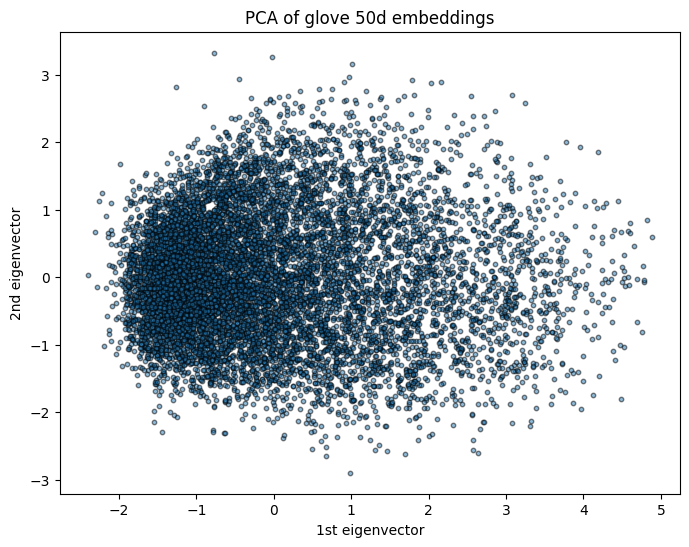

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# visualize the data in 2d
pca = PCA(n_components=2)
glove_50d_subset_data_pca = pca.fit_transform(glove_50d_subset_data)

plt.figure(figsize=(8, 6))
plt.scatter(glove_50d_subset_data_pca[:, 0], glove_50d_subset_data_pca[:, 1], s=10, alpha=0.5, edgecolors='black')
plt.title("PCA of glove 50d embeddings")
plt.xlabel("1st eigenvector")
plt.ylabel("2nd eigenvector")

In [14]:
# run kmeans on the PCA data
print('K means clustering on PCA of glove 50d embeddings')
print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

kmeans = KMeans(init="k-means++", n_clusters=1000, n_init=4, random_state=0)
bench_algorithm(algorithm=kmeans, name="k-means++", data=glove_50d_subset_data_pca, labels=glove_50d_subset_labels)

kmeans = KMeans(init="random", n_clusters=1000, n_init=4, random_state=0)
bench_algorithm(algorithm=kmeans, name="random", data=glove_50d_subset_data_pca, labels=glove_50d_subset_labels)

vae_gmm = BayesianGaussianMixture(n_components=1000)
bench_algorithm(algorithm=vae_gmm, name="vae gmm", data=glove_50d_subset_data, labels=glove_50d_subset_labels)

print(82 * '_')

# VISUALIZATION NOT WORKING

K means clustering on PCA of glove 50d embeddings
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	129.214s	0	0.714	1.000	0.833	0.000	-0.000	-0.288
random   	71.638s	0	0.716	1.000	0.835	0.000	-0.000	-0.274
vae gmm  	67.524s	0	0.716	1.000	0.835	0.000	-0.000	-0.030
__________________________________________________________________________________


----
# Random Clusters for Alignment Checking
- For the alignment checking algorithm, want to find random clusters of words in the embedding space
    - We can find clusters of 100 words by randomly selecting a point in the embedding space and finding the closest 100 points
- Large size of the vocab leads to obscure words selected for clusters
    - Can also define "meaningful" clusters by choosing certain words to be in the cluster

In [13]:
# select 100 random words
# random.seed(0)
random_words = random.sample(list(glove_50d.keys()), 100)
random_words_embeddings = np.array([glove_50d[w] for w in random_words])

glove_50d_data = np.array(list(glove_50d.values()))
glove_50d_labels = np.array(list(glove_50d.keys()))

# for each word, find the 99 nearest neighbours by euclidean distance
from sklearn.metrics import pairwise_distances
distances = pairwise_distances(random_words_embeddings, glove_50d_data, metric='euclidean')
nearest_neighbours = np.argsort(distances, axis=1)[:, 1:100]

# print the first 5 random words and their 5 nearest neighbours
for i, w in enumerate(random_words):
    print(w, [glove_50d_inv[tuple(glove_50d_data[j])] for j in nearest_neighbours[i]][:10])
    if i == 5 : break

reunites ['costars', 'reuniting', 'befriending', 'imagines', 'kidnaps', 'enlists', 'teases', 'costar', 'likens', 'seduces']
toured ['touring', 'alongside', 'collaborated', 'reunited', 'hosted', 'extensively', 'visited', 'notably', 'showcased', 'joined']
mediums ['novelties', 'psychics', 'abstractions', 'concoctions', 'spiritualism', 'fortunetelling', 'conjuring', 'creations', 'multitude', 'intoxicants']
taxable ['dividends', 'annuity', 'payable', 'sum', 'annuities', 'income', 'deferred', 'taxed', 'increment', 'payroll']
maroon ['blazer', 'sported', 'fuchsia', 'berets', 'buckskin', 'sashes', 'striped', 'hoodie', 'purple', 'crimson']
ransomed ['absconded', 'offloaded', 'badgered', 'shushed', 'thereupon', 'speared', 'tricked', 'ejecting', 'expatriated', 'disrobed']
